## Building a model to predict housing prices.

In [1]:
# Let's start by impoprting the required libraries

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas_profiling

In [2]:
import statsmodels.formula.api as smf
from scipy import stats

In [3]:
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.externals import joblib

%matplotlib inline

In [4]:
# Reading in the csv data file.
house = pd.read_csv('House_Prices.csv')
house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


## Exploring the data and finding out relations.

In [5]:
house.describe(percentiles=[0.01,.05,.9,.95,.98,.99])

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,64.500000,130427.343750,2000.937500,3.023438,2.445312,2.578125
std,37.094474,26868.770371,211.572431,0.725951,0.514492,1.069324
min,1.000000,69100.000000,1450.000000,2.000000,2.000000,1.000000
1%,2.270000,81570.000000,1530.800000,2.000000,2.000000,1.000000
5%,7.350000,91310.000000,1664.000000,2.000000,2.000000,1.000000
50%,64.500000,125950.000000,2000.000000,3.000000,2.000000,3.000000
90%,115.300000,166560.000000,2250.000000,4.000000,3.000000,4.000000
95%,121.650000,179465.000000,2368.000000,4.000000,3.000000,4.000000
98%,125.460000,188138.000000,2440.000000,4.000000,3.000000,5.000000


In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
Home            128 non-null int64
Price           128 non-null int64
SqFt            128 non-null int64
Bedrooms        128 non-null int64
Bathrooms       128 non-null int64
Offers          128 non-null int64
Brick           128 non-null object
Neighborhood    128 non-null object
dtypes: int64(6), object(2)
memory usage: 8.1+ KB


In [7]:
# pandas profiling generates a data overview report, it can also generate a html report to view easily.

pandas_profiling.ProfileReport(house)

Number of variables,8
Number of observations,128
Total Missing (%),0.0%
Total size in memory,8.1 KiB
Average record size in memory,64.6 B
Numeric,6
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [8]:
# creating dummy variables for categorical features

dummy = pd.get_dummies(house[['Brick','Neighborhood']],prefix=['Brick','Neighborhood'],drop_first=True)
house_new = pd.concat([house,dummy],axis=1).drop(['Brick','Neighborhood'],axis=1)
house_new.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West
0,1,114300,1790,2,2,2,0,0,0
1,2,114200,2030,4,2,3,0,0,0
2,3,114800,1740,3,2,1,0,0,0
3,4,94700,1980,3,2,3,0,0,0
4,5,119800,2130,3,3,3,0,0,0


In [9]:
# corelation matrix

c = house_new.corr()
c

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick_Yes,Neighborhood_North,Neighborhood_West
Home,1.000000,0.108190,0.168553,-0.068568,0.127694,-0.053597,0.037376,0.049859,0.026873
Price,0.108190,1.000000,0.552982,0.525926,0.523258,-0.313636,0.452817,-0.548221,0.714007
SqFt,0.168553,0.552982,1.000000,0.483807,0.522745,0.336923,0.079792,-0.288886,0.250759
Bedrooms,-0.068568,0.525926,0.483807,1.000000,0.414556,0.114271,0.046380,-0.364667,0.471477
Bathrooms,0.127694,0.523258,0.522745,0.414556,1.000000,0.143793,0.171977,-0.275830,0.285923
Offers,-0.053597,-0.313636,0.336923,0.114271,0.143793,1.000000,-0.144986,0.332987,-0.327425
Brick_Yes,0.037376,0.452817,0.079792,0.046380,0.171977,-0.144986,1.000000,-0.260554,0.115793
Neighborhood_North,0.049859,-0.548221,-0.288886,-0.364667,-0.275830,0.332987,-0.260554,1.000000,-0.479098
Neighborhood_West,0.026873,0.714007,0.250759,0.471477,0.285923,-0.327425,0.115793,-0.479098,1.000000


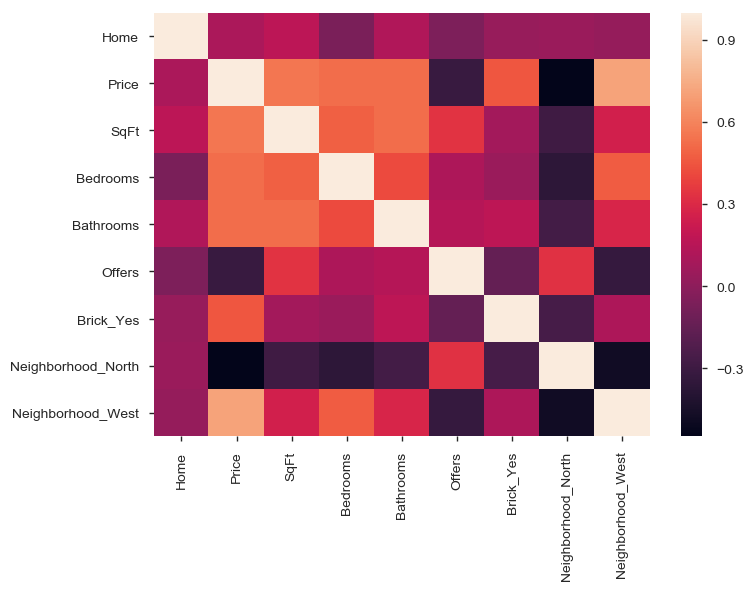

In [10]:
sns.heatmap(c)

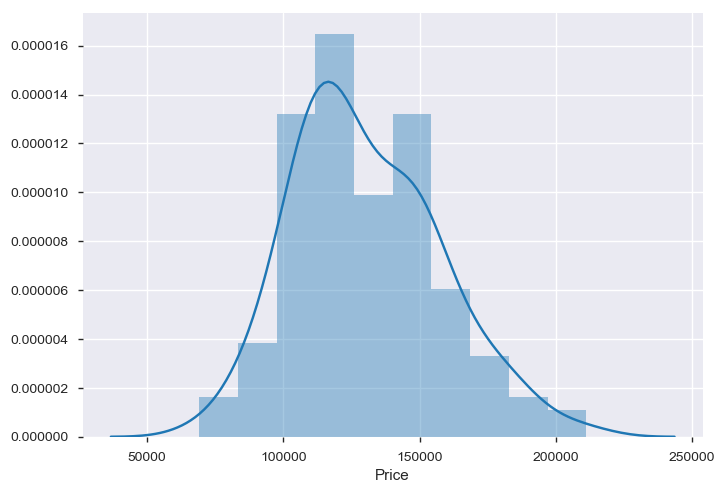

In [11]:
sns.distplot(house_new.Price)

## Now making the stats model, using OLS(ordinary least square) regression.

In [12]:
# the formula
'+'.join(list(house_new.columns))

'Home+Price+SqFt+Bedrooms+Bathrooms+Offers+Brick_Yes+Neighborhood_North+Neighborhood_West'

In [13]:
train,test = train_test_split(house_new,test_size=0.3,random_state=123)

In [14]:
# Without -Neighborhood_North+Bedrooms

lm = smf.ols('Price~SqFt+Bathrooms+Offers+Brick_Yes+Neighborhood_West',data=train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     107.3
Date:                Wed, 24 Jul 2019   Prob (F-statistic):           1.02e-34
Time:                        14:18:03   Log-Likelihood:                -943.70
No. Observations:                  89   AIC:                             1899.
Df Residuals:                      83   BIC:                             1914.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1443.1444   1.02e+0

In [15]:
train["pred_price"] = lm.predict(train)
test["pred_price"] = lm.predict(test)

D:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Programming\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Testing the model performance using error metrices

In [16]:
# error metrics

MAPE = np.mean(np.abs((train.pred_price - train.Price)/train.Price))
MSE = mean_squared_error(train.Price,train.pred_price)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(train.Price,train.pred_price)
CORR = stats.pearsonr(train.Price,train.pred_price)

print(f'For train set =\nMAPE:{MAPE} , MSE:{MSE} , RMSE:{RMSE}, MAE:{MAE} , CORR:{CORR}')

For train set =
MAPE:0.062438150179816986 , MSE:94943058.0936309 , RMSE:9743.872848802517, MAE:7601.4403312637305 , CORR:(0.9305800703743083, 9.849363879023828e-40)


In [17]:
MAPE = np.mean(np.abs((test.pred_price - test.Price)/test.Price))
MSE = mean_squared_error(test.Price,test.pred_price)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(test.Price,test.pred_price)
CORR = stats.pearsonr(test.Price,test.pred_price)

print(f'For test set =\nMAPE:{MAPE} , MSE:{MSE} , RMSE:{RMSE}, MAE:{MAE} , CORR:{CORR}')

For test set =
MAPE:0.06476576023823545 , MSE:116507711.90396468 , RMSE:10793.873813602078, MAE:8242.672478608512 , CORR:(0.9147556689980928, 3.8713462154039296e-16)


## Observing the error

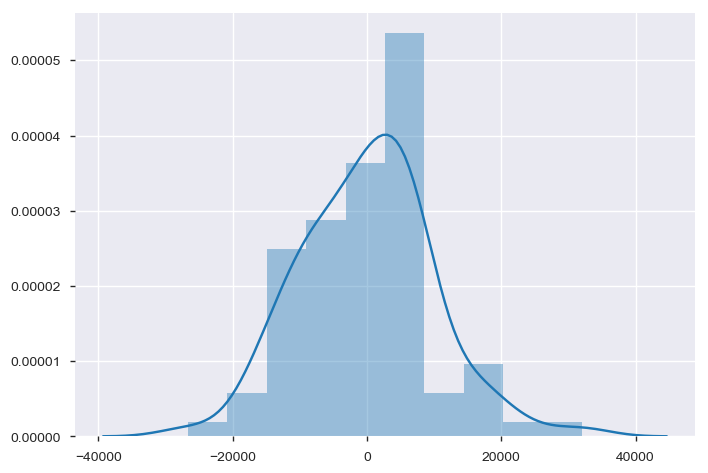

In [18]:
sns.distplot(lm.resid)

In [19]:
lm.resid.mean()

1.63504665487268e-11

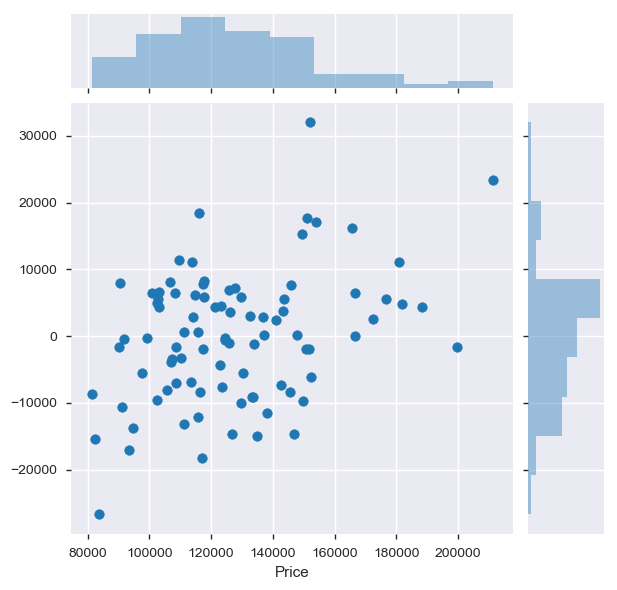

In [20]:
sns.jointplot(train.Price,lm.resid)

## Modelling using LinearRegression

In [21]:
x_train, x_test,Y_train,Y_test = train_test_split(house_new[list(house_new.columns.difference(['Price','Home']))],
                                                  house_new.Price, 
                                                  test_size=0.3,random_state=123)

In [23]:
# checking significance of each featuere using f_score and p_value.

f_val, p_val = f_regression(x_train,Y_train)
pd.DataFrame([[x,y,z] for x,y,z in zip(x_train.columns,f_val,p_val)],columns=['Features','F_score','P_score']).sort_values('F_score')

,Features,F_score,P_score
5,Offers,9.118329,3.320945e-03
2,Brick_Yes,17.946216,5.627857e-05
6,SqFt,33.868206,9.637168e-08
1,Bedrooms,34.366676,8.018258e-08
3,Neighborhood_North,35.489779,5.314058e-08
0,Bathrooms,40.152992,1.004869e-08
4,Neighborhood_West,90.933770,3.589176e-15


In [24]:
lr = LinearRegression()
lr.fit(x_train,Y_train)
p = lr.predict(x_test)

In [25]:
np.sqrt(mean_squared_error(Y_test,p))

10475.428354540785

In [26]:
# Error check using cross validation score

lr = LinearRegression()
round( np.mean( cross_val_score( lr, x_train, Y_train, scoring = 'r2', cv = 10 )), 2)

0.77

In [27]:
resid = (p-Y_test)/Y_test

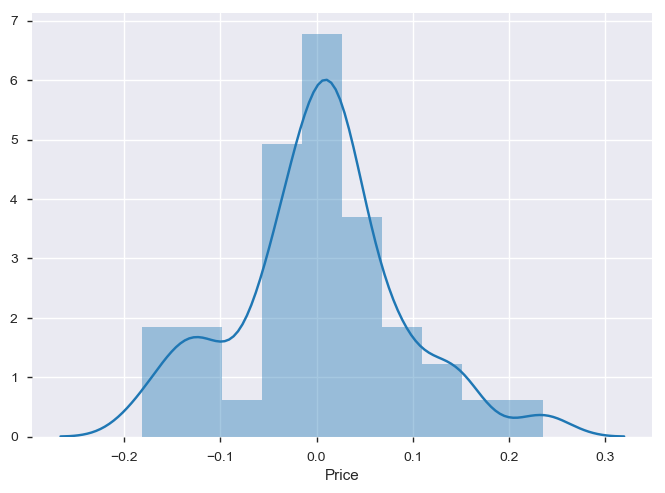

In [28]:
sns.distplot(resid)

## Saving the built model to an external file for reuse

In [29]:
joblib.dump(lr,'lin_reg_model',compress=3)

['lin_reg_model']